In [1]:
import pandas as pd
from dataclasses import dataclass

import matplotlib.pyplot as plt

In [2]:
dataset_snow = pd.read_pickle('/Users/redleader/PycharmProjects/norlab_WMRD/data/marmotte/ga_hard_snow_25_01_a/splited_set/slip_dataset_all_train.pkl')
# '/home/dominic/repos/norlab_WMRD/data/marmotte/ga_hard_snow_25_01_a/slip_dataset_all.pkl' # snow

# ToDo: add a small dataset to the repository for example purpose instead

# Using *aggregate_multiple_features*

```python
def aggregate_multiple_features(
        dataset_frame: pd.DataFrame,
        dataset_info: str,
        features_config: dict[str, Union[Type[AbstractFeatureDataclass], tuple[str, ...]]]) -> dataclass:
```

- param `dataset_frame`: Dataset as a panda dataframe
- param `dataset_info`: Any relevant information pertaining to the dataset (location, robot, condition ...)
- param `features_config`: The features to agregate from the dataset as a configuration dictionary

## 1. Base case

Extract multiple features from a dataset (formated in a dataframe) based on a configuration dictionary.

The `features_config` specify the feature name to lookout in the `dataset_frame` header and agregate them in a `Multifeature` dataclass. Feature dimensions such as 'x', 'y' 'z' are specified either by using existing `AbstractFeatureDataclass` subclass such as: `StatePose2D`, `CmdStandard`, `CmdSkidSteer`, `Velocity`, `VelocitySkidSteer` or by using tuple of strings such as `('<new feature dataclass type name>', '<dimension names 1>', '<dimension names 2>', ...)`.

        >>> feature_config = {
        >>>             'icp_interpolated': StatePose2D,
        >>>             'idd_vel':          StatePose2D,
        >>>             'icp':              ('StatePose3D', 'x', 'y', 'z', 'roll', 'pitch', 'yaw')
        >>>             }

Note that each `AbstractFeatureDataclass` subclass validate that each dimension have uniform shape and have monotonic increassing timestep index without skip


In [3]:
from multifeature_aggregator import aggregate_multiple_features, StatePose2D

In [4]:
features_config_1 = {
    'body_vel_disturption': StatePose2D,
    'icp_interpolated': StatePose2D,
    'icp_vel': StatePose2D,
    'idd_vel': StatePose2D,
    'icp':     ('StatePose3D', 'x', 'y', 'z', 'roll', 'pitch', 'yaw')
}

mf1 = aggregate_multiple_features(dataset_snow,
                                  dataset_info="Robot: marmotte, Details: ga_hard_snow_25_01_a",
                                  features_config=features_config_1)

In [5]:
print(mf1)


Multifeature(
   dataset_info: Robot: marmotte, Details: ga_hard_snow_25_01_a
   aggregated_date: 2023-02-20 13:42:12.223885
   body_vel_disturption: 
          StatePose2D(
              feature_name: body_vel_disturption
              sample_size: 309
              trajectory_len: 40
              dimensions:
                 x: ndarray (309, 40)
                 y: ndarray (309, 40)
                 yaw: ndarray (309, 40)
              )
   icp_interpolated: 
          StatePose2D(
              feature_name: icp_interpolated
              sample_size: 309
              trajectory_len: 40
              dimensions:
                 x: ndarray (309, 40)
                 y: ndarray (309, 40)
                 yaw: ndarray (309, 40)
              )
   icp_vel: 
          StatePose2D(
              feature_name: icp_vel
              sample_size: 309
              trajectory_len: 40
              dimensions:
                 x: ndarray (309, 40)
                 y: ndarray (309, 40)
    


## 2. Case requiring post-processing

1. Just create a new dataclass inheriting from a `AbstractFeatureDataclass` subclass e.g. `StatePose2D`
2. Overide `post_init_callback` with the desired post-processing process

In [6]:
steady_state_mask = dataset_snow['steady_state_mask'].to_numpy() == True

@dataclass
class StatePose2DSteadyState(StatePose2D):
    def post_init_callback(self, feature_name):
        feature = self.__getattribute__(feature_name)
        self.__setattr__(feature_name, feature[steady_state_mask])
        return None

In [7]:
features_config_steady_state = {
    'body_vel_disturption': StatePose2DSteadyState,
    'icp_interpolated': StatePose2DSteadyState,
    'icp_vel': StatePose2DSteadyState,
    'idd_vel': StatePose2DSteadyState,
}

mfs = aggregate_multiple_features(dataset_snow,
                                  dataset_info="Robot: marmotte, Details: ga_hard_snow_25_01_a, STEADY STATE",
                                  features_config=features_config_steady_state)

In [8]:
print(mfs)


Multifeature(
   dataset_info: Robot: marmotte, Details: ga_hard_snow_25_01_a, STEADY STATE
   aggregated_date: 2023-02-20 13:42:12.243074
   body_vel_disturption: 
          StatePose2DSteadyState(
              feature_name: body_vel_disturption
              sample_size: 206
              trajectory_len: 40
              dimensions:
                 x: ndarray (206, 40)
                 y: ndarray (206, 40)
                 yaw: ndarray (206, 40)
              )
   icp_interpolated: 
          StatePose2DSteadyState(
              feature_name: icp_interpolated
              sample_size: 206
              trajectory_len: 40
              dimensions:
                 x: ndarray (206, 40)
                 y: ndarray (206, 40)
                 yaw: ndarray (206, 40)
              )
   icp_vel: 
          StatePose2DSteadyState(
              feature_name: icp_vel
              sample_size: 206
              trajectory_len: 40
              dimensions:
                 x: ndarray (206,

## You can access each features and their dimension by property call

In [9]:
mf1.idd_vel.x.shape == mf1.icp_vel.x.shape == mf1.body_vel_disturption.x.shape

True

## and print the multifeature of any feature summary

In [10]:
print(mf1.body_vel_disturption)


          StatePose2D(
              feature_name: body_vel_disturption
              sample_size: 309
              trajectory_len: 40
              dimensions:
                 x: ndarray (309, 40)
                 y: ndarray (309, 40)
                 yaw: ndarray (309, 40)
              )


## Now, `aggregate_multiple_features` function replace all the follwing lines

In [11]:
# # extract body_vel_distruptions arrays (output arrays)
#
# str_body_vel_disturption_x_list = []
# str_body_vel_disturption_y_list = []
# str_body_vel_disturption_yaw_list = []
# for i in range(0, 40):
#     str_body_vel_disturption_x_i = 'body_vel_disturption_x_' + str(i)
#     str_body_vel_disturption_y_i = 'body_vel_disturption_y_' + str(i)
#     str_body_vel_disturption_yaw_i = 'body_vel_disturption_yaw_' + str(i)
#     str_body_vel_disturption_x_list.append(str_body_vel_disturption_x_i)
#     str_body_vel_disturption_y_list.append(str_body_vel_disturption_y_i)
#     str_body_vel_disturption_yaw_list.append(str_body_vel_disturption_yaw_i)
#
# body_vel_disturption_x_array = dataset_snow[str_body_vel_disturption_x_list].to_numpy()
# body_vel_disturption_y_array = dataset_snow[str_body_vel_disturption_y_list].to_numpy()
# body_vel_disturption_yaw_array = dataset_snow[str_body_vel_disturption_yaw_list].to_numpy()

In [12]:
# # extract interpolated_icp
#
# str_icp_interpolated_x_list = []
# str_icp_interpolated_y_list = []
# str_icp_interpolated_yaw_list = []
# for i in range(0, 40):
#     str_icp_interpolated_x_i = 'icp_interpolated_x_' + str(i)
#     str_icp_interpolated_y_i = 'icp_interpolated_y_' + str(i)
#     str_icp_interpolated_yaw_i = 'icp_interpolated_yaw_' + str(i)
#     str_icp_interpolated_x_list.append(str_icp_interpolated_x_i)
#     str_icp_interpolated_y_list.append(str_icp_interpolated_y_i)
#     str_icp_interpolated_yaw_list.append(str_icp_interpolated_yaw_i)
#
# icp_interpolated_x_array = dataset_snow[str_icp_interpolated_x_list].to_numpy()
# icp_interpolated_y_array = dataset_snow[str_icp_interpolated_y_list].to_numpy()
# icp_interpolated_yaw_array = dataset_snow[str_icp_interpolated_yaw_list].to_numpy()

In [13]:
# # extract icp vels
#
# str_icp_vel_x_list = []
# str_icp_vel_y_list = []
# str_icp_vel_yaw_list = []
# for i in range(0, 40):
#     str_icp_vel_x_i = 'icp_vel_x_' + str(i)
#     str_icp_vel_y_i = 'icp_vel_y_' + str(i)
#     str_icp_vel_yaw_i = 'icp_vel_yaw_' + str(i)
#     str_icp_vel_x_list.append(str_icp_vel_x_i)
#     str_icp_vel_y_list.append(str_icp_vel_y_i)
#     str_icp_vel_yaw_list.append(str_icp_vel_yaw_i)
#
# icp_vel_x_array = dataset_snow[str_icp_vel_x_list].to_numpy()
# icp_vel_y_array = dataset_snow[str_icp_vel_y_list].to_numpy()
# icp_vel_yaw_array = dataset_snow[str_icp_vel_yaw_list].to_numpy()

In [14]:
# # extract cmd_body_vel arrays (input arrays)
#
# idd_body_vel_x_str_list = []
# idd_body_vel_y_str_list = []
# idd_body_vel_yaw_str_list = []
# for i in range(0, 40):
#     str_idd_vel_x_i = 'idd_vel_x_' + str(i)
#     str_idd_vel_y_i = 'idd_vel_y_' + str(i)
#     str_idd_vel_yaw_i = 'idd_vel_yaw_' + str(i)
#     idd_body_vel_x_str_list.append(str_idd_vel_x_i)
#     idd_body_vel_y_str_list.append(str_idd_vel_y_i)
#     idd_body_vel_yaw_str_list.append(str_idd_vel_yaw_i)
#
# idd_body_vel_x_array = dataset_snow[idd_body_vel_x_str_list].to_numpy()
# idd_body_vel_y_array = dataset_snow[idd_body_vel_y_str_list].to_numpy()
# idd_body_vel_yaw_array = dataset_snow[idd_body_vel_yaw_str_list].to_numpy()

In [15]:
# # compute mean body vel disturbance for each steady-state window
# n_windows = len(dataset_snow)
#
# steady_state_mask = dataset_snow['steady_state_mask'].to_numpy() == True
#
# steady_state_idd_body_vel_x = idd_body_vel_x_array[steady_state_mask]
# steady_state_idd_body_vel_y = idd_body_vel_y_array[steady_state_mask]
# steady_state_idd_body_vel_yaw = idd_body_vel_yaw_array[steady_state_mask]
#
# steady_state_icp_body_vel_x = icp_vel_x_array[steady_state_mask]
# steady_state_icp_body_vel_y = icp_vel_y_array[steady_state_mask]
# steady_state_icp_body_vel_yaw = icp_vel_yaw_array[steady_state_mask]
#
# steady_state_body_vel_disturption_x = body_vel_disturption_x_array[steady_state_mask]
# steady_state_body_vel_disturption_y = body_vel_disturption_y_array[steady_state_mask]
# steady_state_body_vel_disturption_yaw = body_vel_disturption_yaw_array[steady_state_mask]

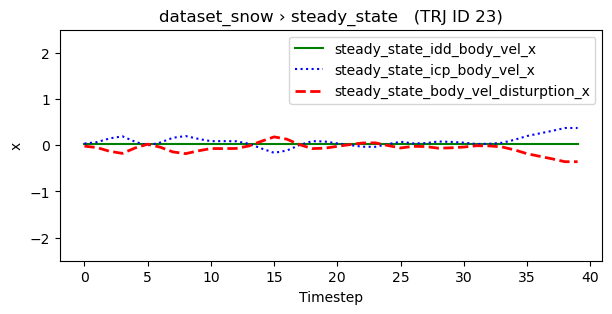

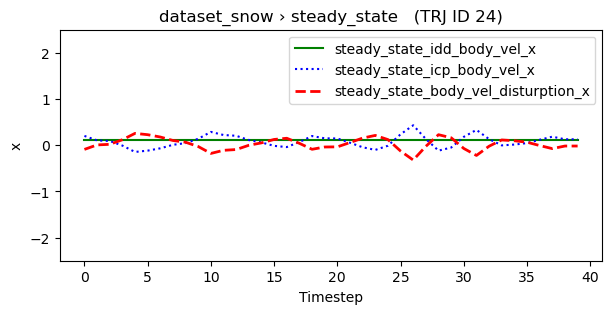

In [16]:
def plot_dataset_trajectory_steady_state_x_array(trajectory_id: int, title: str, y_label:str, ylim: tuple=(-2.5, 2.5)):
    fig = plt.figure(num=None, figsize=(7,3), dpi=None, facecolor=None, edgecolor=None)
    plt.title(f'{title}   (TRJ ID {trajectory_id})')
    plt.plot(mfs.idd_vel.x[trajectory_id, :], label="steady_state_idd_body_vel_x", color="green")
    plt.plot(mfs.icp_vel.x[trajectory_id, :], label="steady_state_icp_body_vel_x", color="blue", linestyle="dotted")
    plt.plot(mfs.body_vel_disturption.x[trajectory_id, :], label="steady_state_body_vel_disturption_x", color="red", linestyle="dashed", linewidth="2.")
    plt.legend()
    plt.ylabel(y_label)
    plt.xlabel('Timestep')
    plt.ylim(*ylim)
    return None

# _ids = [62,29,30,31,32]
_ids = range(23,25)
for _trj_id in _ids:
    plot_dataset_trajectory_steady_state_x_array(trajectory_id=_trj_id, title="dataset_snow › steady_state", y_label="x", ylim=(-2.5, 2.5))

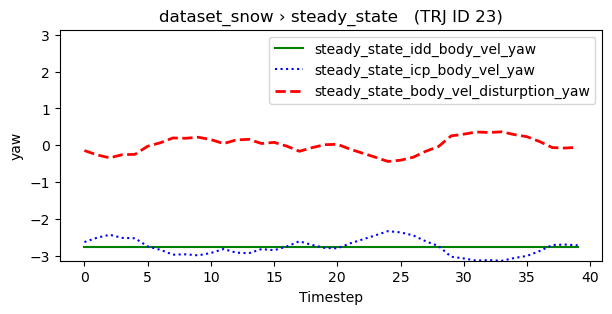

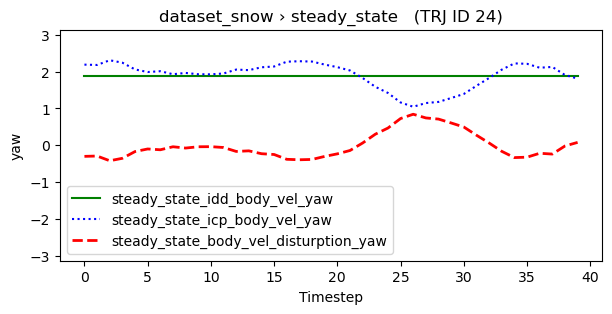

In [17]:
def plot_dataset_trajectory_steady_state_yaw(trajectory_id: int, title: str, y_label:str, ylim: tuple=(-2.5, 2.5)):
    fig = plt.figure(num=None, figsize=(7,3), dpi=None, facecolor=None, edgecolor=None)
    plt.title(f'{title}   (TRJ ID {trajectory_id})')
    plt.plot(mfs.idd_vel.yaw[trajectory_id, :], label="steady_state_idd_body_vel_yaw", color="green")
    plt.plot(mfs.icp_vel.yaw[trajectory_id, :], label="steady_state_icp_body_vel_yaw", color="blue", linestyle="dotted")
    plt.plot(mfs.body_vel_disturption.yaw[trajectory_id, :], label="steady_state_body_vel_disturption_yaw", color="red", linestyle="dashed", linewidth="2.")
    plt.legend()
    plt.ylabel(y_label)
    plt.xlabel('Timestep')
    plt.ylim(*ylim)
    return None

# _ids = [29,30,31,32]
_ids = range(23,25)
for _trj_id in _ids:
    plot_dataset_trajectory_steady_state_yaw(trajectory_id=_trj_id, title="dataset_snow › steady_state", y_label="yaw", ylim=(-3.1416, 3.1416))
